In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [45]:
df = pd.read_csv('data1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [46]:
df.isna().sum().sum()

1434

In [47]:
df.duplicated().sum()

0

In [48]:
df.dropna(inplace=True)
df.shape

(2011, 10)

In [49]:
df.isna().sum().sum()

0

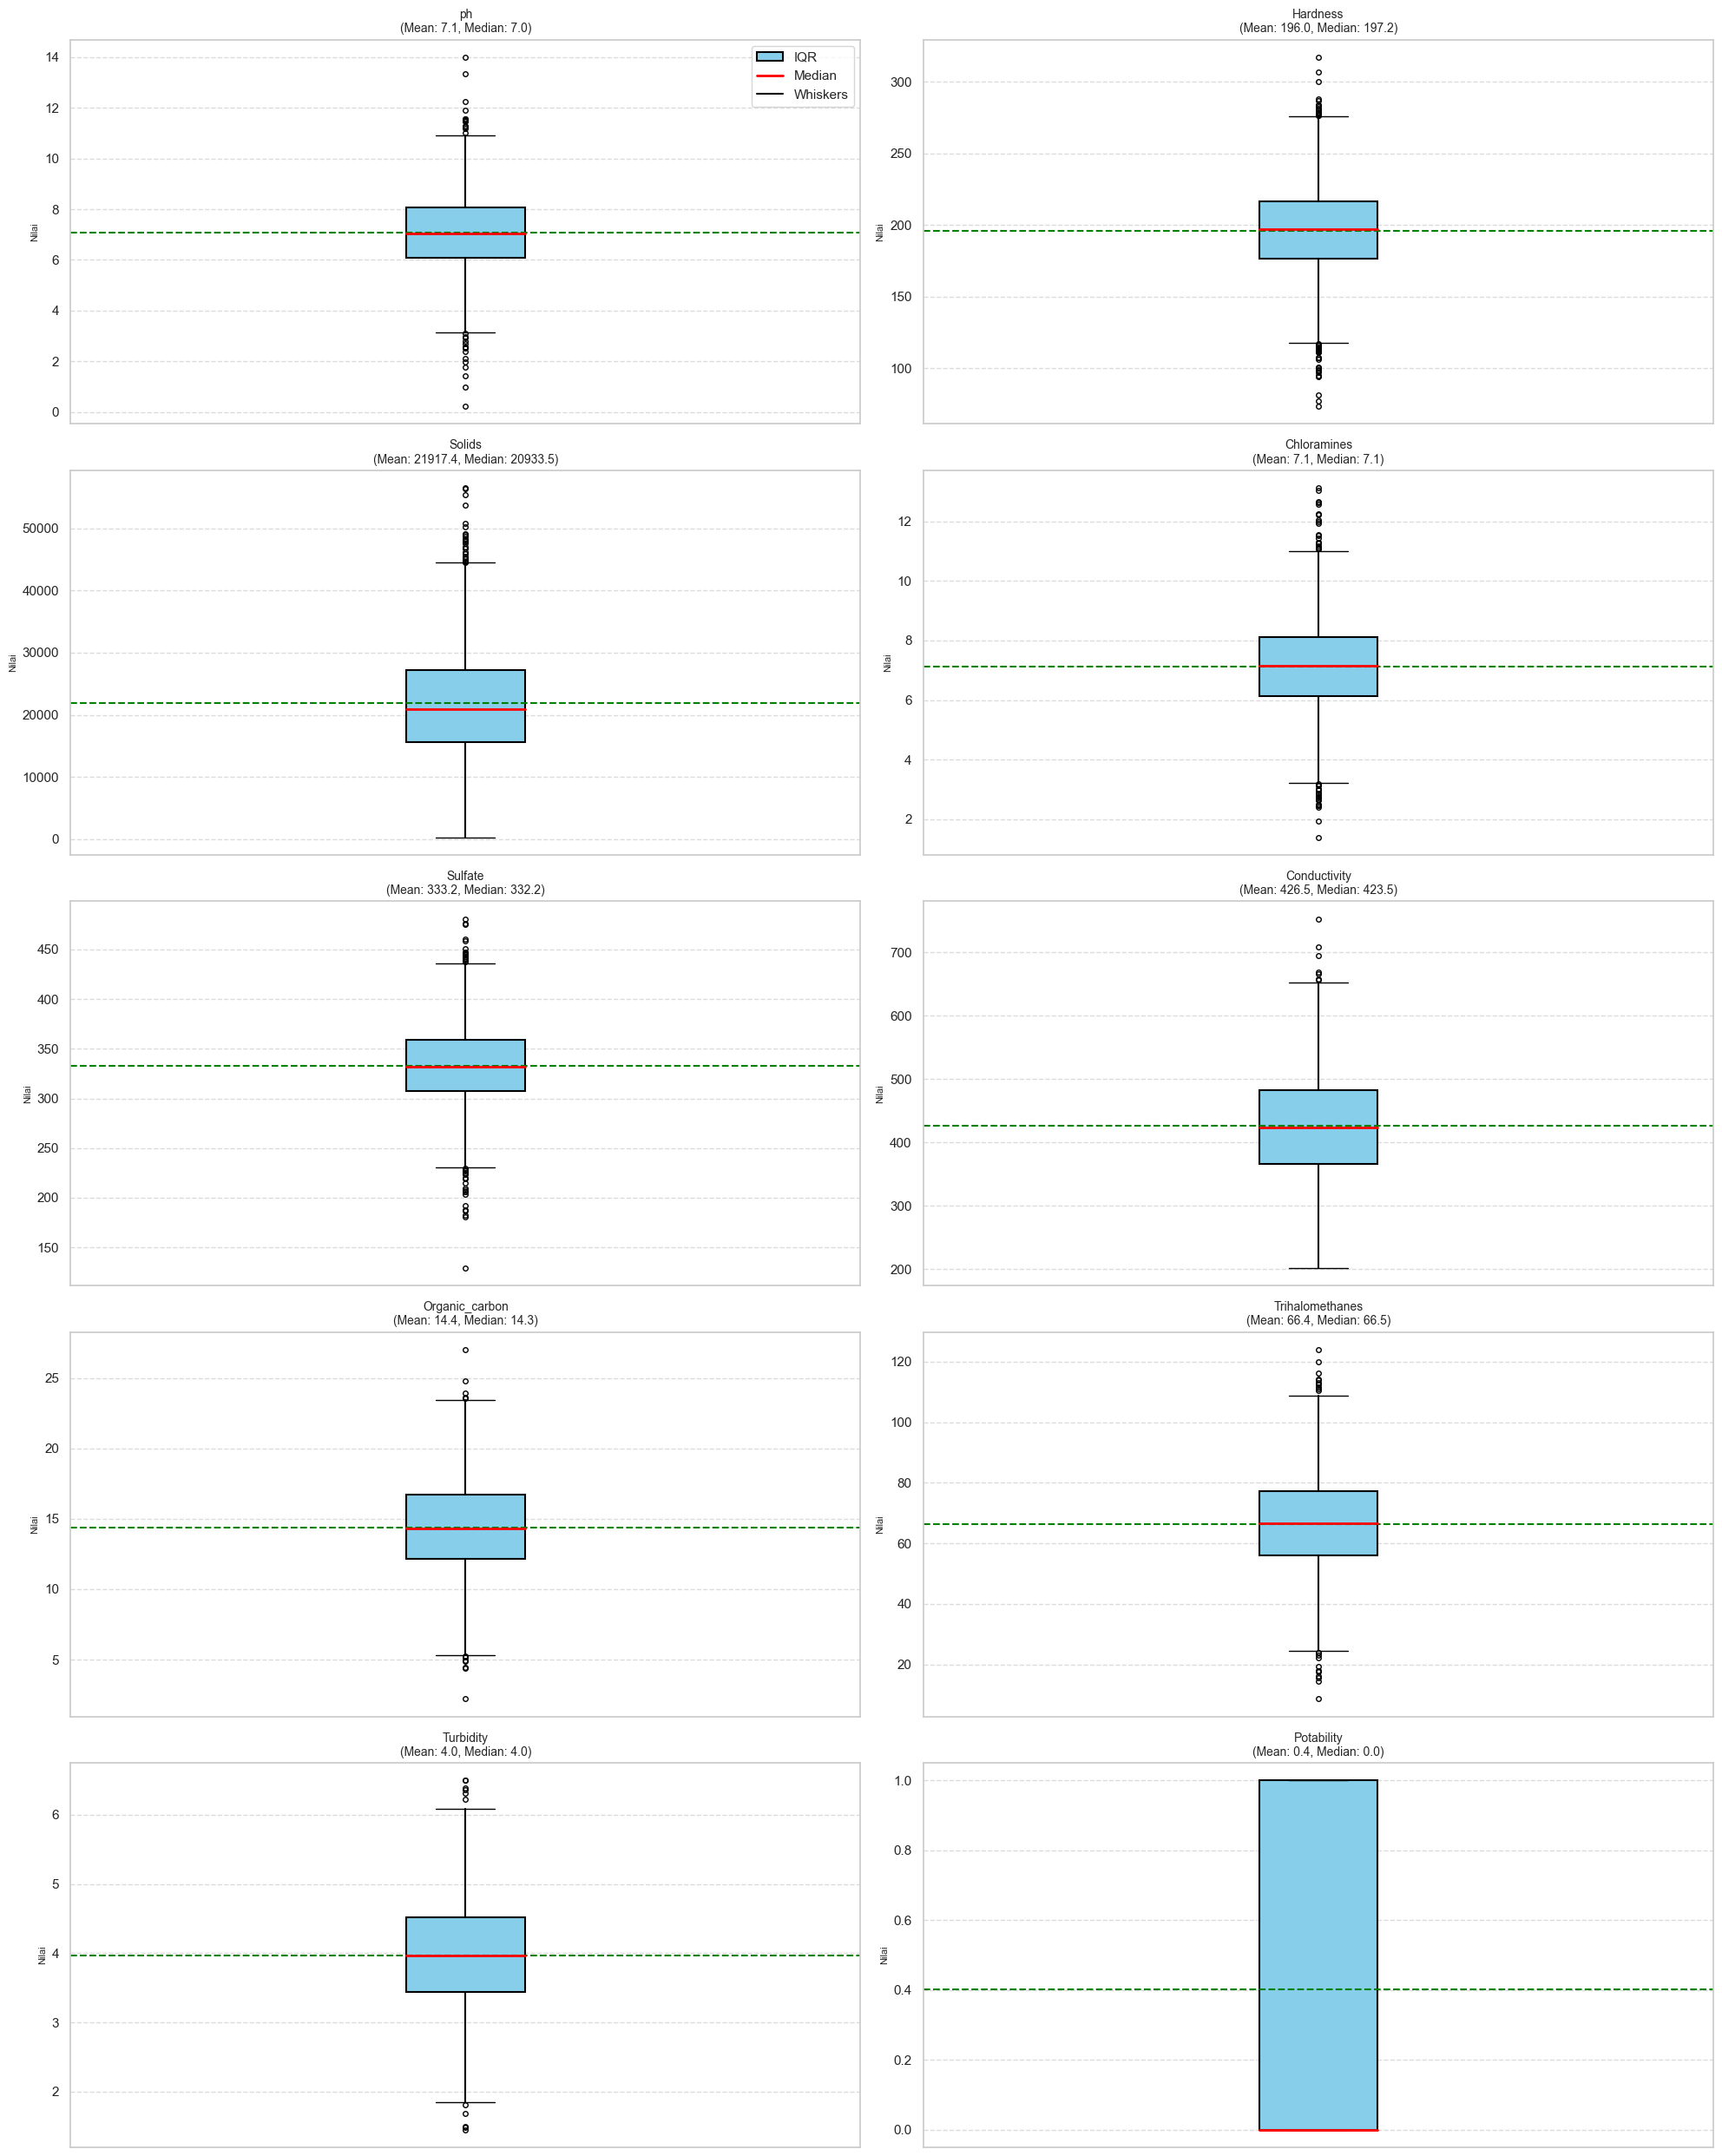

In [50]:
sns.set_theme(style='whitegrid')
numerical_cols = df.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

boxprops = dict(facecolor='skyblue', linewidth=1.5)
whiskerprops = dict(color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df[col].dropna()
    
    bp = axis.boxplot(data,
                      vert=True,
                      patch_artist=True,
                      boxprops=boxprops,
                      whiskerprops=whiskerprops,
                      medianprops=medianprops,
                      flierprops=dict(marker='o', markersize=4))
    
    mean_val = data.mean()
    axis.axhline(mean_val, color='green', linestyle='--', linewidth=1.5)
    
    axis.set_title(f'{col}\n(Mean: {mean_val:.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_ylabel('Nilai', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    axis.set_xticks([])
    
    if i == 0:  
        axis.legend([bp['boxes'][0], bp['medians'][0], bp['whiskers'][0]], 
                   ['IQR', 'Median', 'Whiskers'],
                   loc='upper right')

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

In [51]:
df2 = df.copy()

In [52]:
def outlier_remover(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.4*IQR
    upper_bound = Q3 + 1.4*IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [53]:
num_col = df2.select_dtypes(include='number').columns
for i in num_col.tolist():
    df2 = outlier_remover(df2, i)

print(f"Sebelum penghapusan outlier {df.shape} setelah {df2.shape}")

Sebelum penghapusan outlier (2011, 10) setelah (1710, 10)


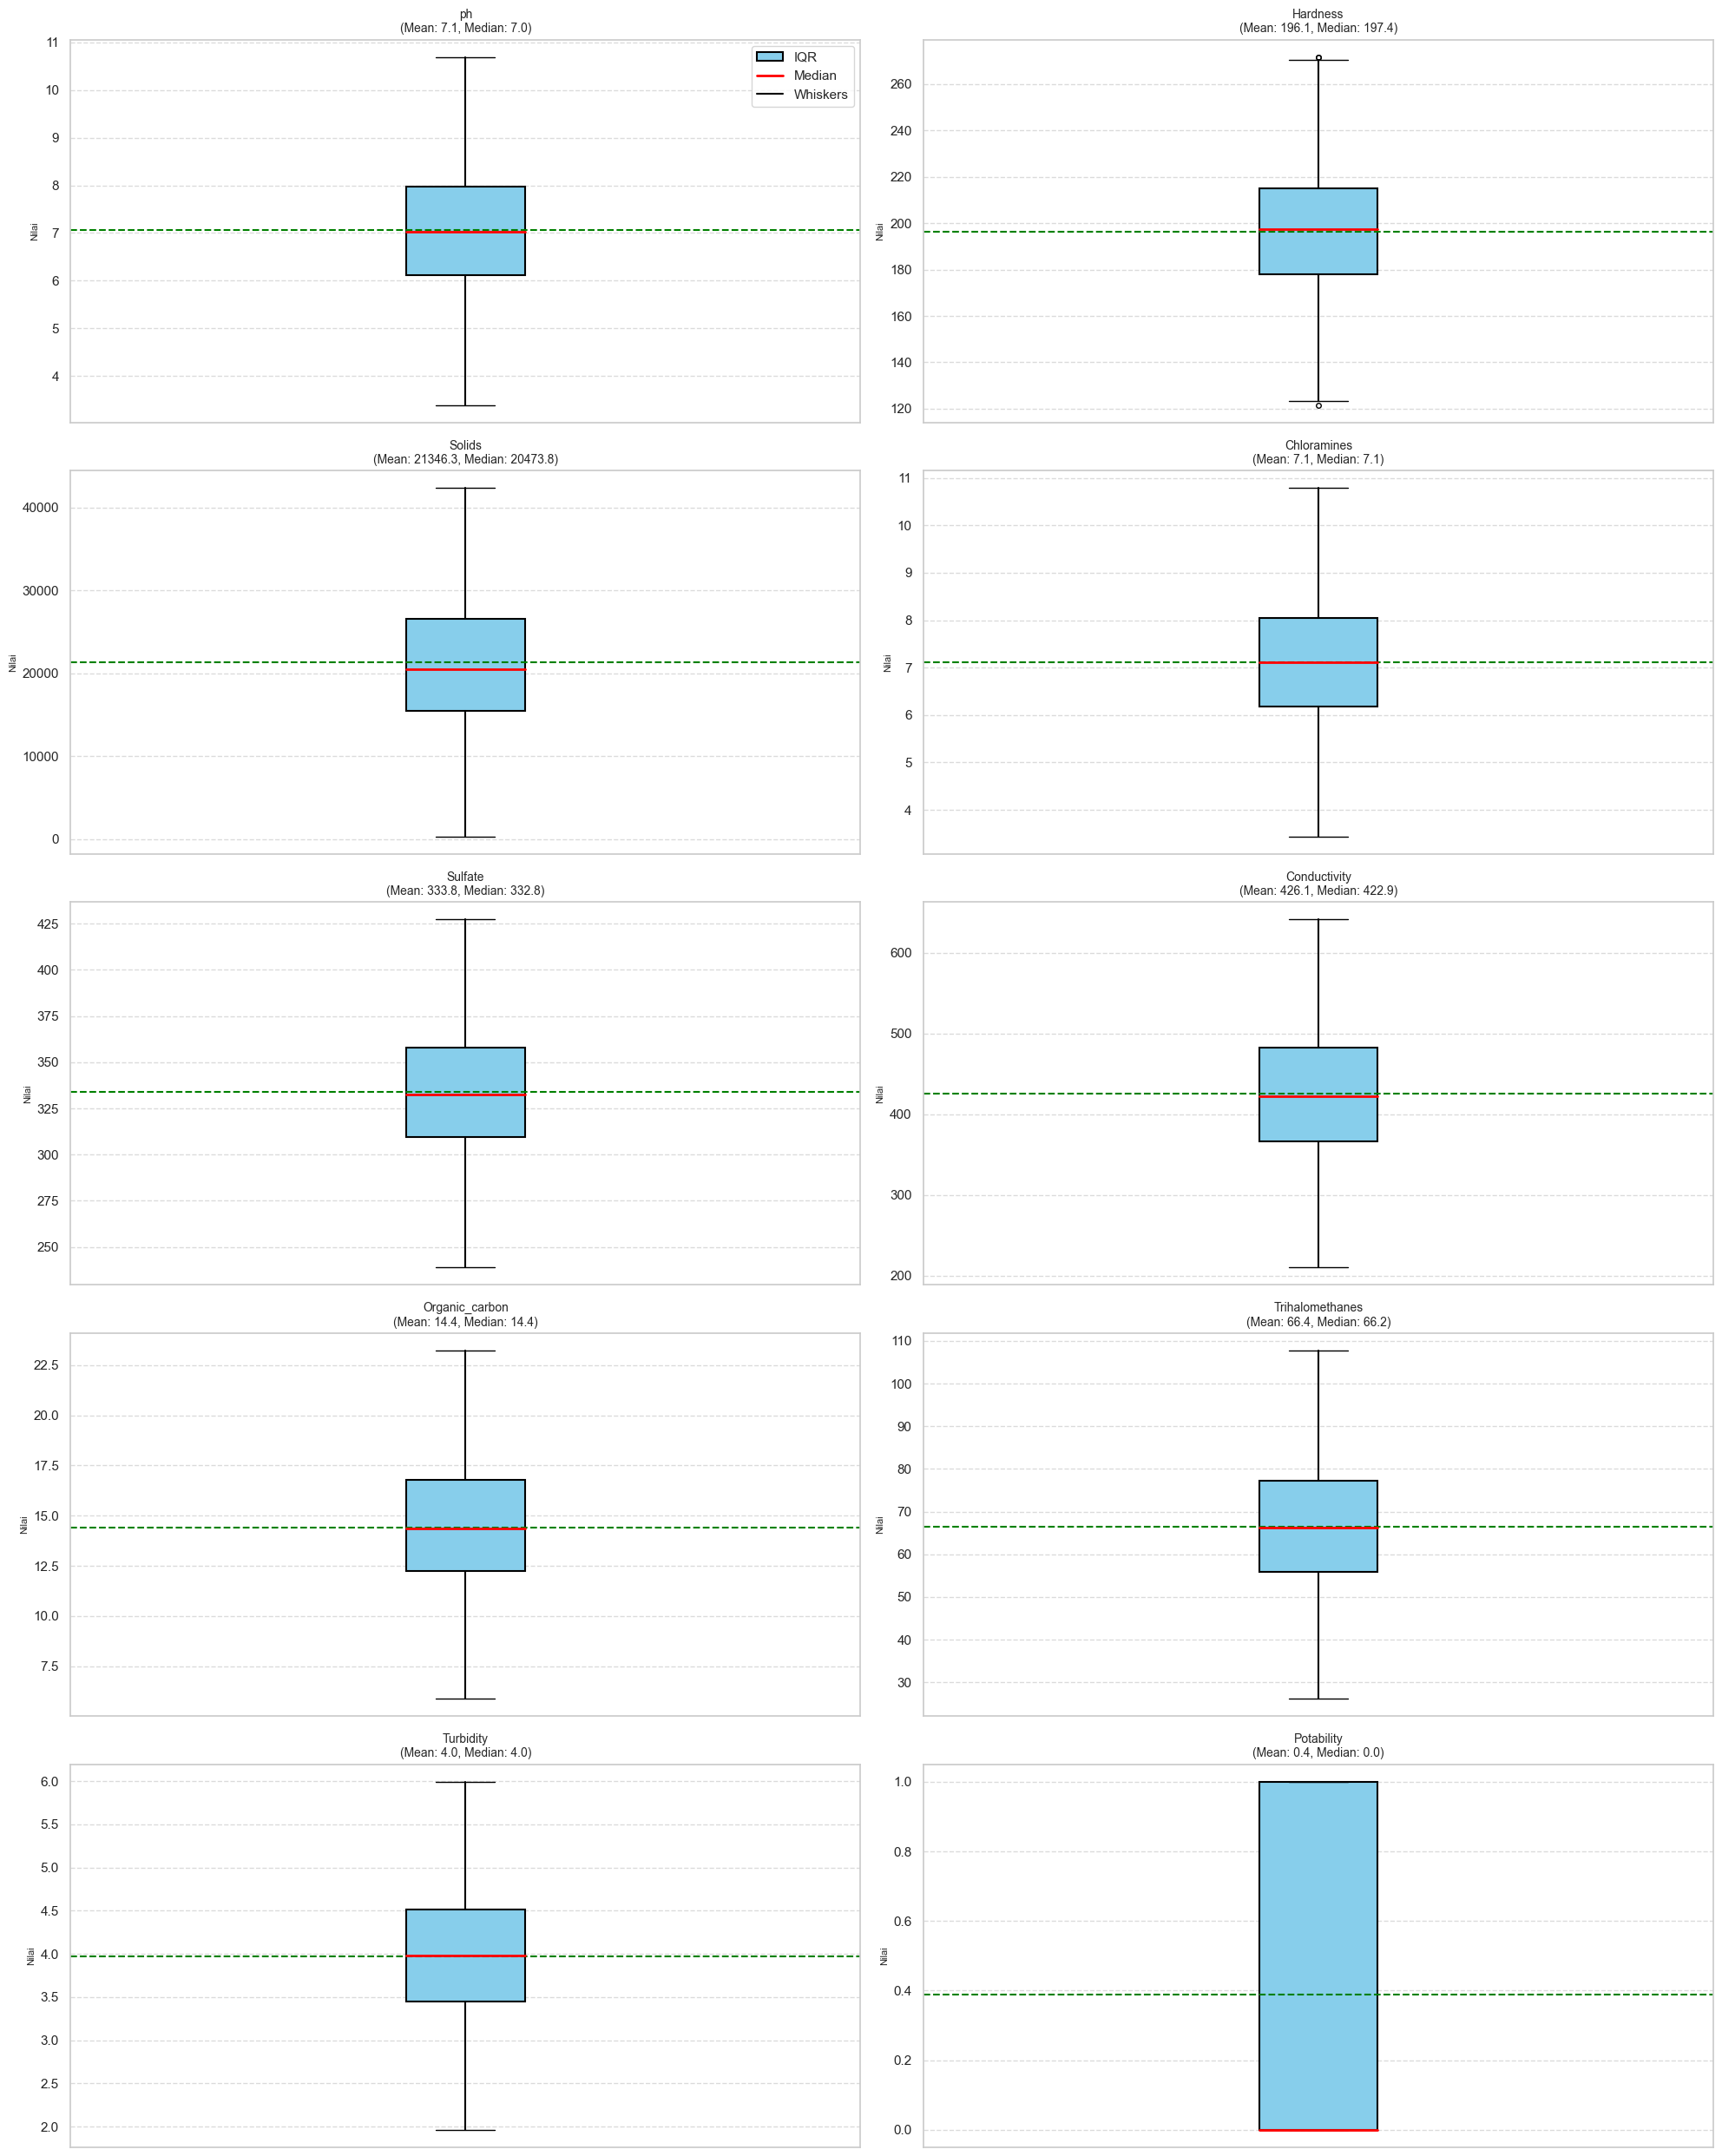

In [54]:
sns.set_theme(style='whitegrid')
numerical_cols = df2.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

boxprops = dict(facecolor='skyblue', linewidth=1.5)
whiskerprops = dict(color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df2[col].dropna()
    
    bp = axis.boxplot(data,
                      vert=True,
                      patch_artist=True,
                      boxprops=boxprops,
                      whiskerprops=whiskerprops,
                      medianprops=medianprops,
                      flierprops=dict(marker='o', markersize=4))
    
    mean_val = data.mean()
    axis.axhline(mean_val, color='green', linestyle='--', linewidth=1.5)
    
    axis.set_title(f'{col}\n(Mean: {mean_val:.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_ylabel('Nilai', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    axis.set_xticks([])
    
    if i == 0:  
        axis.legend([bp['boxes'][0], bp['medians'][0], bp['whiskers'][0]], 
                   ['IQR', 'Median', 'Whiskers'],
                   loc='upper right')

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

In [55]:
df['Potability'].value_counts()

0    1200
1     811
Name: Potability, dtype: int64

In [56]:
x1 = df.drop(columns='Potability')
y1 = df['Potability']

x2 = df2.drop(columns='Potability')
y2 = df2['Potability']

In [57]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1,y1,test_size=0.2,random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2,y2,test_size=0.2,random_state=42)

In [58]:
ct = CatBoostClassifier(random_state=42, verbose=0)
ct.fit(x_train1,y_train1)
y_pred_ct1 = ct.predict(x_test1)

ct2 = CatBoostClassifier(random_state=42, verbose=0)
ct2.fit(x_train2,y_train2)
y_pred_ct2 = ct2.predict(x_test2)

akurasi_cb1 = accuracy_score(y_test1, y_pred_ct1)
f1_cb1 = f1_score(y_test1, y_pred_ct1)
akurasi_cb2 = accuracy_score(y_test2, y_pred_ct2)
f1_cb2 = f1_score(y_test2, y_pred_ct2)

In [59]:
print(f"hasil D1 Akuarasi: {akurasi_cb1}    f1: {f1_cb1}")
print(f"hasil D2 Akuarasi: {akurasi_cb2}    f1: {f1_cb2}")

hasil D1 Akuarasi: 0.6799007444168734    f1: 0.5567010309278351
hasil D2 Akuarasi: 0.6432748538011696    f1: 0.42452830188679247


In [60]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train1,y_train1)
y_pred_rf1 = rf.predict(x_test1)

rf2 = RandomForestClassifier(random_state=42)
rf2.fit(x_train2,y_train2)
y_pred_rf2 = rf2.predict(x_test2)

akurasi_rf1 = accuracy_score(y_test1, y_pred_rf1)
f1_rf1 = f1_score(y_test1, y_pred_rf1)
akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
f1_rf2 = f1_score(y_test2, y_pred_rf2)

In [61]:
print(f"hasil D1 Akuarasi: {akurasi_rf1}    f1: {f1_rf1}")
print(f"hasil D2 Akuarasi: {akurasi_rf2}    f1: {f1_rf2}")

hasil D1 Akuarasi: 0.652605459057072    f1: 0.49640287769784175
hasil D2 Akuarasi: 0.6286549707602339    f1: 0.4147465437788018


In [62]:
estimator = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
max_depth = [1, 10, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
min_samples_split = [0.1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
min_samples_leaf = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
max_features= ['sqrt']
max_samples= [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
criterion = ['gini', 'entropy', 'log_loss']

for i in estimator:
    rf = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=25, min_samples_split=2, min_samples_leaf=1, criterion='gini' )
    rf.fit(x_train1,y_train1)
    y_pred_rf1 = rf.predict(x_test1)


#n_estimators=400
    # rf2 = RandomForestClassifier(random_state=42)
    # rf2.fit(x_train2,y_train2)
    # y_pred_rf2 = rf2.predict(x_test2)

    akurasi_rf1 = accuracy_score(y_test1, y_pred_rf1)
    f1_rf1 = f1_score(y_test1, y_pred_rf1)
    # akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
    # f1_rf2 = f1_score(y_test2, y_pred_rf2)
    print(f"hasil D1 pada {i} Akuarasi: {akurasi_rf1}    f1: {f1_rf1}")
# print(f"max {max(max_depth)}")

hasil D1 pada 100 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 200 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 300 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 400 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 500 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 600 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 700 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 800 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 900 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665
hasil D1 pada 1000 Akuarasi: 0.6799007444168734    f1: 0.5342960288808665


In [ ]:
estimator = [50,75,90,95,100,105, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
max_depth = [1, 10, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
min_samples_split = [0.1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
min_samples_leaf = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
max_features= ['sqrt']
max_samples= [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in min_samples_leaf:
    rf = RandomForestClassifier(random_state=42, n_estimators=75, max_depth=25, min_samples_split=10, min_samples_leaf=1)
    rf.fit(x_train2,y_train2)
    y_pred_rf2 = rf.predict(x_test2)

    # rf2 = RandomForestClassifier(random_state=42)
    # rf2.fit(x_train2,y_train2)
    # y_pred_rf2 = rf2.predict(x_test2)

    akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
    f1_rf2 = f1_score(y_test2, y_pred_rf2)
    # akurasi_rf2 = accuracy_score(y_test2, y_pred_rf2)
    # f1_rf2 = f1_score(y_test2, y_pred_rf2)
    print(f"hasil D1 pada {i} Akuarasi: {akurasi_rf2}    f1: {f1_rf2}")
# print(f"max {max(max_depth)}")

hasil D1 pada 0.1 Akuarasi: 0.5906432748538012    f1: 0.0
hasil D1 pada 1 Akuarasi: 0.652046783625731    f1: 0.45662100456621
hasil D1 pada 2 Akuarasi: 0.6403508771929824    f1: 0.4484304932735427
hasil D1 pada 4 Akuarasi: 0.6432748538011696    f1: 0.419047619047619
hasil D1 pada 6 Akuarasi: 0.6198830409356725    f1: 0.38095238095238093
hasil D1 pada 8 Akuarasi: 0.6549707602339181    f1: 0.41000000000000003
hasil D1 pada 10 Akuarasi: 0.6345029239766082    f1: 0.371859296482412
hasil D1 pada 12 Akuarasi: 0.6432748538011696    f1: 0.37755102040816324
hasil D1 pada 14 Akuarasi: 0.6345029239766082    f1: 0.3523316062176166
hasil D1 pada 16 Akuarasi: 0.652046783625731    f1: 0.37696335078534027
hasil D1 pada 18 Akuarasi: 0.6491228070175439    f1: 0.36170212765957444
hasil D1 pada 20 Akuarasi: 0.6345029239766082    f1: 0.3243243243243243


In [64]:
results = []

# Generate 50 random seeds
random_states = np.random.randint(0, 10000, size=50)

for seed in random_states:
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

    # Buat model
    model = RandomForestClassifier(random_state=seed, n_estimators=400, max_depth=25, min_samples_split=2, min_samples_leaf=1)
    model.fit(x_train, y_train)

    # Prediksi
    y_pred = model.predict(x_test)

    # Hitung f1_score
    f1 = f1_score(y_test, y_pred)

    # Simpan hasil
    results.append((seed, f1))

# Cari random_state terbaik
best_seed, best_f1 = max(results, key=lambda x: x[1])

print(f"Best random_state: {best_seed} dengan F1 Score: {best_f1:.4f}")

Best random_state: 9239 dengan F1 Score: 0.5527


Best random_state: 2752 dengan F1 Score: 0.6903

Best random_state: 8440 dengan F1 Score: 0.6937

Best random_state: 8865 dengan F1 Score: 0.6990

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42, stratify=y1)

model = RandomForestClassifier(random_state=6022, n_estimators=400, max_depth=25, min_samples_split=2, min_samples_leaf=1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

acc,f1


(0.7344913151364765, 0.5931558935361216)

RF

1. hasil D1 Akuarasi: 0.652605459057072    
2. f1: 0.49640287769784175

1. hasil D2 Akuarasi: 0.6759776536312849    
2. f1: 0.46296296296296297

CT:

hasil D1 Akuarasi: 0.6799007444168734    f1: 0.5567010309278351
hasil D2 Akuarasi: 0.6731843575418994    f1: 0.48000000000000004

In [66]:
results = []

# Generate 50 random states
random_states = np.random.randint(0, 10000, size=50)

for seed in random_states:
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42, stratify=y1)
    
    # Buat model
    model = RandomForestClassifier(
        random_state=seed, n_estimators=400, max_depth=25, min_samples_split=2, min_samples_leaf=1
    )
    model.fit(x_train, y_train)

    # Prediksi
    y_pred = model.predict(x_test)

    # Hitung metrik
    f1 = f1_score(y_test, y_pred)  # cocok untuk multilabel / imbalance
    acc = accuracy_score(y_test, y_pred)

    # Simpan hasil
    results.append((seed, acc, f1))

    # Print setiap hasil
    # print(f"Random State {seed}: Akurasi = {acc:.4f}, F1 Score = {f1:.4f}")

# Cari random state dengan Akurasi terbaik
best_acc_seed, best_acc, _ = max(results, key=lambda x: x[1])

# Cari random state dengan F1 terbaik
best_f1_seed, _, best_f1 = max(results, key=lambda x: x[2])

print("\n=== Hasil Terbaik ===")
print(f"Best Random State by Akurasi: {best_acc_seed} | Akurasi: {best_acc:.4f}")
print(f"Best Random State by F1 Score: {best_f1_seed} | F1 Score: {best_f1:.4f}")


=== Hasil Terbaik ===
Best Random State by Akurasi: 9847 | Akurasi: 0.7246
Best Random State by F1 Score: 1788 | F1 Score: 0.5778


In [78]:
results = []

# Generate 50 random states
random_states = np.random.randint(0, 10000, size=50)

for seed in random_states:
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)
    
    # Buat model
    model = RandomForestClassifier(random_state=seed, n_estimators=75, max_depth=25, min_samples_split=10, min_samples_leaf=1)
    model.fit(x_train, y_train)

    # Prediksi
    y_pred = model.predict(x_test)

    # Hitung metrik
    f1 = f1_score(y_test, y_pred)  # cocok untuk multilabel / imbalance
    acc = accuracy_score(y_test, y_pred)

    # Simpan hasil
    results.append((seed, acc, f1))

    # Print setiap hasil
    # print(f"Random State {seed}: Akurasi = {acc:.4f}, F1 Score = {f1:.4f}")

# Cari random state dengan Akurasi terbaik
best_acc_seed, best_acc, _ = max(results, key=lambda x: x[1])

# Cari random state dengan F1 terbaik
best_f1_seed, _, best_f1 = max(results, key=lambda x: x[2])

print("\n=== Hasil Terbaik ===")
print(f"Best Random State by Akurasi: {best_acc_seed} | Akurasi: {best_acc:.4f}")
print(f"Best Random State by F1 Score: {best_f1_seed} | F1 Score: {best_f1:.4f}")


=== Hasil Terbaik ===
Best Random State by Akurasi: 2100 | Akurasi: 0.6696
Best Random State by F1 Score: 2100 | F1 Score: 0.4695


In [79]:
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=2100, n_estimators=75, max_depth=25, min_samples_split=10, min_samples_leaf=1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

acc,f1


(0.6695906432748538, 0.4694835680751174)

In [80]:
rf22 = RandomForestClassifier()
rf22.fit(x_train1, y_train1)

RandomForestClassifier()